<a href="https://colab.research.google.com/github/eisenjulian/avg-bleu/blob/main/avg_bleu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Selectively Answering Visual Questions](https://aclanthology.org/2024.findings-acl.250/)

Recently, large multi-modal models (LMMs) have emerged with the capacity to perform vision tasks such as captioning and visual question answering (VQA) with unprecedented accuracy. Applications such as helping the blind or visually impaired have a critical need for precise answers. It is specially important for models to be well calibrated and be able to quantify their uncertainty in order to selectively decide when to answer and when to abstain or ask for clarifications. We perform the first in-depth analysis of calibration methods and metrics for VQA with in-context learning LMMs. Studying VQA on two answerability benchmarks, we show that the likelihood score of visually grounded models is better calibrated than in their text-only counterparts for in-context learning, where sampling based methods are generally superior, but no clear winner arises. We propose Avg BLEU, a calibration score combining the benefits of both sampling and likelihood methods across modalities.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eisenjulian/avg-bleu/blob/main/avg-bleu.ipynb)

In [3]:
# @title Install Dependencies

! pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.3 MB/s eta 0:00:00


In [10]:
# @title Import Dependencies

import tensorflow_hub
import tensorflow_text
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import numpy as np
from scipy.special import softmax
import functools
import itertools
import shelve
import tqdm

import io
import itertools
from typing import Iterable, Sequence
import time
import json
import collections
import math

import PIL
import tqdm
import pandas as pd
import numpy as np
import sklearn.metrics
import sklearn.calibration
import matplotlib.pyplot as plt
import sacrebleu
import functools
import urllib.request

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17414176044423059335
xla_global_id: -1
]


In [5]:
# @title Set Up Models

VOCAB_PATH = 'gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12/vocab.txt' # @param {"type":"string"}
EQUIVALENCE_MODEL_PATH = 'https://tfhub.dev/google/answer_equivalence/bem/1' # @param {"type":"string"}

vocab_table = tf.lookup.StaticVocabularyTable(
        tf.lookup.TextFileInitializer(
            filename=VOCAB_PATH,
            key_dtype=tf.string,
            key_index=tf.lookup.TextFileIndex.WHOLE_LINE,
            value_dtype=tf.int64,
            value_index=tf.lookup.TextFileIndex.LINE_NUMBER
        ),
        num_oov_buckets=1)
cls_id, sep_id = vocab_table.lookup(tf.convert_to_tensor(['[CLS]', '[SEP]']))
tokenizer = tensorflow_text.BertTokenizer(vocab_lookup_table=vocab_table,
                               token_out_type=tf.int64,
                               preserve_unused_token=True,
                               lower_case=True)

# with tf.device("/gpu:0"):
bem = tensorflow_hub.load(EQUIVALENCE_MODEL_PATH)

def _bertify_example(example):
  question = tokenizer.tokenize(example['question']).merge_dims(1, 2)
  reference = tokenizer.tokenize(example['reference']).merge_dims(1, 2)
  candidate = tokenizer.tokenize(example['candidate']).merge_dims(1, 2)

  input_ids, segment_ids = tensorflow_text.combine_segments(
      (candidate, reference, question), cls_id, sep_id)

  return {'input_ids': input_ids.numpy(), 'segment_ids': segment_ids.numpy()}


def _pad(a, length=512):
  return np.append(a, np.zeros(length - a.shape[-1], np.int32))


def _bertify_examples(examples):
  input_ids = []
  segment_ids = []
  for example in examples:
    example_inputs = _bertify_example(example)
    input_ids.append(_pad(example_inputs['input_ids']))
    segment_ids.append(_pad(example_inputs['segment_ids']))

  return {'input_ids': np.stack(input_ids), 'segment_ids': np.stack(segment_ids)}


def _run_bem(question, uniq, shelf):
  key = str((question, uniq))
  if key in shelf:
    return shelf[key]
  result = []
  values = list(itertools.permutations(uniq, 2))
  bs = 128
  for start in range(0, len(values), bs):
    inputs = _bertify_examples([{
        'question': question,
        'reference': reference,
        'candidate': candidate,
    } for reference, candidate in values[start:start + bs]])
    result.extend(softmax(bem(inputs), axis=1)[:, 1].tolist())
  shelf[key] = result
  return result

def _get_pairwise_bem(question, weighted_outputs, shelf) -> tuple[float, float]:
  texts = [t for t, _ in weighted_outputs]
  uniq = tuple(sorted(set(s for s in texts if s != UNK)))
  cache = {(a, a): 1 for a in uniq}
  cache[(UNK, UNK)] = 1.0
  for a in uniq:
    cache[(UNK, a)] = 0.0
    cache[(a, UNK)] = 0.0
  if len(uniq) > 1:
    scores = _run_bem(question, uniq, shelf)
    for (a, b), s in zip(itertools.permutations(uniq, 2), scores):
      cache[(a, b)] = s

  avg = np.mean([np.mean([cache[(a, b)] for b in texts]) for a in texts])
  mx = max((np.mean([cache[(a, b)] for b in texts]) for a in texts if a != UNK), default=0.0)
  wavg = np.mean([sum([cache[(a, b)] * w for b, w in weighted_outputs]) for a in texts])
  wmx = max((sum([cache[(a, b)]  * w for b, w in weighted_outputs]) for a in texts if a != UNK), default=0.0)
  return avg, mx, wavg, wmx

In [7]:
# @title Helper methods

UNK = "unanswerable"

def _clean_unk(text: str) -> str:
  text = text.lower()
  if "cannot answer" in text or "unsuitable" in text or "unanswerable" in text or 'unknown' in text:
    return UNK
  return text.replace("<extra_id_0> ", "").strip()

@functools.lru_cache(10000)
def _bleu(x: str, y: str) -> float:
  if x == y: return 1.0
  if x == UNK: return 0.0
  return min(1, sacrebleu.corpus_bleu([x], [[y]],
                        smooth_method="exp",
                        smooth_value=0.0,
                        force=False,
                        lowercase=False,
                        tokenize='intl',
                        use_effective_order=True).score / 100)

def _get_scores(example, compute_bem: bool, shelf) -> list[float] | None:
  answers = [_clean_unk(a) for a in example['answers'] if a != '<unk>']
  if not answers:
    return None
  # gold_trigger = sum(2 for a in answers if a != UNK) >= len(answers)
  gold_trigger = any(a != UNK for a in answers)
  outputs = [_clean_unk(o) for o in example['outputs']]
  best_score, selected_output = max(zip(example['scores'], outputs))
  if best_score > 0:
    raise ValueError('Your scores are not log likelihoods!')
  pred_trigger = selected_output != UNK
  is_correct = gold_trigger and selected_output != UNK and selected_output in answers
  counter = collections.Counter(outputs)
  diversity = 1 - (len(counter) / len(outputs))
  repetitions = counter.most_common(1)[0][1] / len(outputs)
  p = np.array([counter[x] / len(outputs) for x in outputs])
  inv_ppl = 2 ** np.sum(p * np.log2(p))
  unk_ratio = 1 - (counter[UNK] / len(outputs))
  # avg_rouge = np.mean([t5_metrics.rouge([t], [p])['rouge1'] / 100 for t, p in itertools.permutations(outputs, 2)])
  # rescale = min(1, len(outputs) * math.exp(best_score) / counter[selected_output])
  # factor = math.exp(best_score) / (0.00001 + sum(
  #     math.exp(score) / counter[output]
  #     for score, output in zip(example['scores'], outputs)))
  weighted_outputs = [
      (output, math.exp(score) / len(outputs)) # * factor / counter[output])
      for score, output in zip(example['scores'], outputs)]
  avg_bleu = 1 * np.mean(
      [np.mean([_bleu(t, p) for p in outputs]) for t in outputs])
  rep_bleu = 1 * max(
      (np.mean([_bleu(t, p) for p in outputs]) for t in outputs if t != UNK),
      default=0.0)

  avg_wbleu = np.mean(
      [sum(_bleu(t, p) * w for p, w in weighted_outputs) for t in outputs])
  rep_wbleu = max(
      (sum(_bleu(t, p) * w for p, w in weighted_outputs)
      for t in outputs if t != UNK),
      default=0.0)

  if compute_bem:
    avg_bem, rep_bem, avg_wbem, rep_wbem = _get_pairwise_bem(example['question'], weighted_outputs, shelf)
  else:
    avg_bem, rep_bem, avg_wbem, rep_wbem = 1.0, 1.0, 1.0, 1.0

  if avg_wbleu > 1.0 or rep_wbleu > 1.0:
    raise ValueError('Score is too big')

  return (example['key'], example['question'], answers, outputs, selected_output, gold_trigger, pred_trigger, is_correct,
          math.exp(best_score),
          diversity,
          repetitions,
          inv_ppl,
          unk_ratio,
          avg_bleu,
          rep_bleu,
          avg_wbleu,
          rep_wbleu,
          avg_bem, rep_bem, avg_wbem, rep_wbem
          )

returned_columns = (
    'key question answers outputs selected_output gold_trigger pred_trigger '
    'is_correct likelihood diversity repetitions inverse_perplexity unk_ratio '
    'avg_bleu rep_bleu avg_wbleu rep_wbleu avg_bem rep_bem avg_wbem rep_wbem').split()

def _get_precision_boundary(
    precisions_thresholds: Sequence[tuple[float, float]],
    prec_boundary: float) -> float:
  """Computes the precision and threshold given a precision boundary."""
  valid_thresholds = (thr for prec, thr in precisions_thresholds
                      if prec >= prec_boundary)
  return min(valid_thresholds, default=float('INF'))

def _expected_calibration_error(
    is_correct: Sequence[float],
    score: Sequence[float],
    num_ece_bins: int = 10) -> tuple[Sequence[float], Sequence[float], float]:
  """Computes the expected calibration error (ECE) for arrays of preds and labels."""
  ece_prob_true, ece_prob_pred = sklearn.calibration.calibration_curve(
      y_true=is_correct, y_prob=score, n_bins=num_ece_bins)
  bin_counts = np.histogram(score, bins=num_ece_bins, range=(0, 1 + 1e-8))[0]
  nonzero_bin_counts = bin_counts[bin_counts > 0]
  return ece_prob_true, ece_prob_pred, np.average(
      np.abs(ece_prob_true - ece_prob_pred), weights=nonzero_bin_counts)

100%|██████████| 538/538 [00:01<00:00, 470.52it/s]


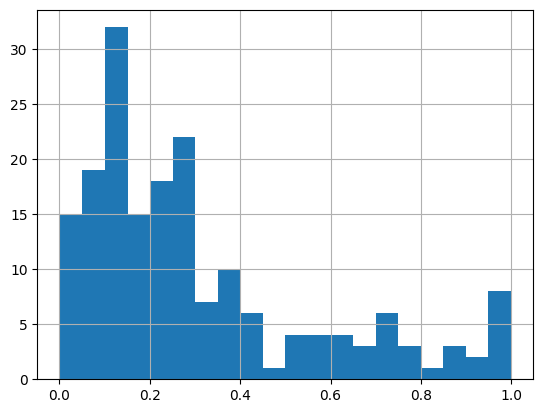

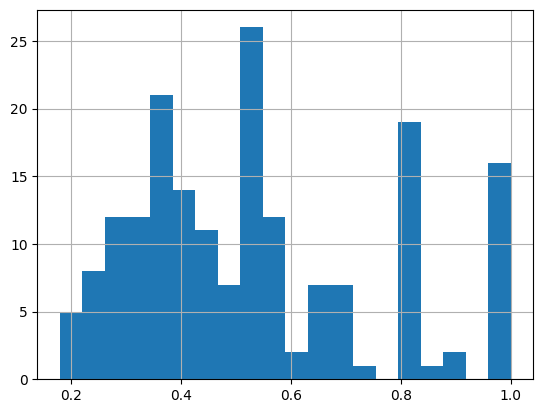

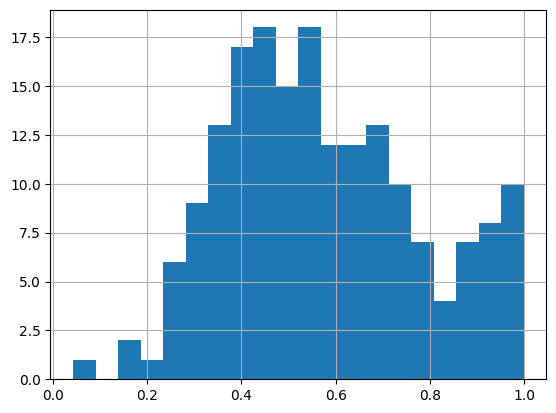

vizwiz/llava_13b_4bit
 - Answerable Rate 0.912639405204461
 - Triggering rate 0.34014869888475835
 - Accuracy 0.6120218579234973


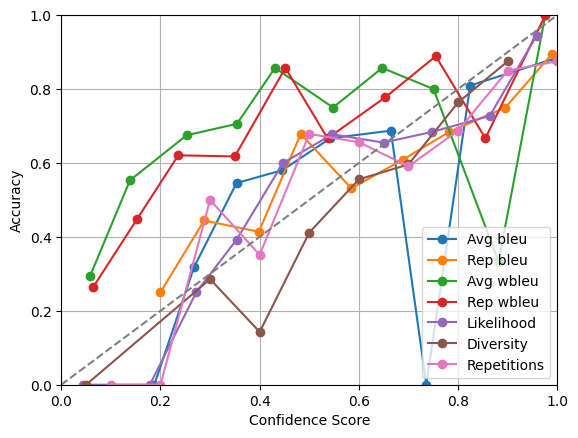

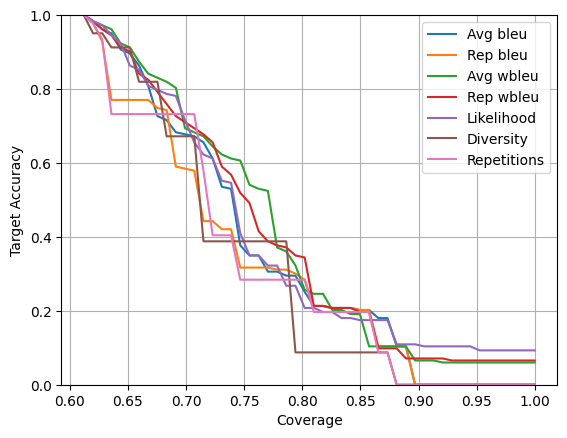

,Score,ROC AUC,ECE,Cov@20,Cov@30,Cov@40,Cov@50,Cov@60,Cov@70,Cov@80,Cov@90
0,Avg bleu,0.688003,0.111322,1.0,1.0,1.0,1.0,1.0,0.677596,0.251366,0.000000
1,Rep bleu,0.665933,0.096432,1.0,1.0,1.0,1.0,1.0,0.584699,0.300546,0.000000
2,Avg wbleu,0.709507,0.321457,1.0,1.0,1.0,1.0,1.0,0.693989,0.300546,0.065574
3,Rep wbleu,0.699824,0.255471,1.0,1.0,1.0,1.0,1.0,0.710383,0.344262,0.071038
4,Likelihood,0.687500,0.078635,1.0,1.0,1.0,1.0,1.0,0.715847,0.207650,0.109290
5,Diversity,0.703659,0.068306,1.0,1.0,1.0,1.0,1.0,0.672131,0.087432,0.000000
6,Repetitions,0.693473,0.098907,1.0,1.0,1.0,1.0,1.0,0.732240,0.284153,0.000000


In [15]:
# @title Plot Curves
model = 'vizwiz/llava_13b_4bit' # @param ["vizwiz/llava_13b_4bit"]
data_path = 'https://raw.githubusercontent.com/eisenjulian/avg-bleu/refs/heads/main/data/{}.jsonl'

run_bem = False # @param {type:"boolean"}
plotted_scores = 'avg_bleu rep_bleu avg_wbleu rep_wbleu likelihood diversity repetitions'.split()
if run_bem:
  plotted_scores.extend('avg_bem rep_bem avg_wbem rep_wbem'.split())
precision_boundaries = (20, 30, 40, 50, 60, 70, 80, 90)



def eval_model(model, plotted_scores, precision_boundaries, render_plots=True, shelf=dict()):
  lines = []
  with urllib.request.urlopen(data_path.format(model)) as f:
    for line in tqdm.tqdm(f.read().decode('utf-8').splitlines()):
      json_line = json.loads(line)
      # if json_line.get('alter_type') in ('semantic negation', 'image mask', 'image copy and move'):
      #   continue
      parsed_line = _get_scores(json_line,
                                run_bem,
                                shelf)
      if parsed_line is not None:
        lines.append(parsed_line)
        if run_bem and hasattr(shelf, 'sync'): shelf.sync()
  scores = pd.DataFrame(lines, columns=returned_columns)
  triggered_scores = scores[scores.pred_trigger]
  if render_plots:
    triggered_scores.avg_wbleu.hist(bins=20)
    plt.show()
    triggered_scores.avg_bleu.hist(bins=20)
    plt.show()
    triggered_scores.likelihood.hist(bins=20)
    plt.show()

  acc = triggered_scores.is_correct.mean()
  trigger_rate = scores.pred_trigger.mean()
  all_boundaries = np.linspace(triggered_scores.is_correct.mean(), 1.0, 50)
  print(model)
  print(' - Answerable Rate', scores.gold_trigger.mean())
  print(' - Triggering rate', trigger_rate)
  print(' - Accuracy', acc)

  all_metrics = []
  cov_metrics = []
  for score_col in plotted_scores:
    score_display = score_col.replace('_', ' ').capitalize()
    score = triggered_scores[score_col]
    roc_auc = sklearn.metrics.roc_auc_score(triggered_scores.is_correct, score)
    precisions = [(triggered_scores.is_correct[score >= thr].mean(), thr)
                  for thr in sorted(set(score))]
    ece_y, ece_x, ece = _expected_calibration_error(
        triggered_scores.is_correct, score)
    metrics = [score_display, roc_auc, ece]
    if render_plots:
      plt.plot(ece_x, ece_y, linestyle='-', marker='o', label=score_display)
    cov_metrics.append([])
    for boundary in all_boundaries:
      threshold = _get_precision_boundary(precisions, boundary)
      cov_metrics[-1].append((score >= threshold).mean())
    for boundary in precision_boundaries:
      threshold = _get_precision_boundary(precisions, boundary / 100)
      metrics.append((score >= threshold).mean())
    all_metrics.append(metrics)

  if render_plots:
    plt.xlabel("Confidence Score")
    plt.ylabel("Accuracy")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.savefig('calibration.pdf')
    plt.show()

    for score_col, values in zip(plotted_scores, cov_metrics):
      score_display = score_col.replace('_', ' ').capitalize()
      plt.plot(all_boundaries, values, label=score_display)

    # plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.xlabel("Coverage")
    plt.ylabel("Target Accuracy")
    plt.savefig('coverage.pdf')
    plt.show()

  return acc, trigger_rate, pd.DataFrame(all_metrics, columns=['Score', 'ROC AUC', 'ECE'] + [f'Cov@{k}' for k in precision_boundaries]), scores

with shelve.open('bem_cache', writeback=True) as shelf:
  _, _, df, samples = eval_model(model, plotted_scores, precision_boundaries, True, shelf)
df